In [6]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

BASE_PATH = 'archive/Technology Companies/'

# AAPL_CSV = 'archive/Technology Companies/ACN.csv'

In [7]:
def load_data(csv_path):
    data=pd.read_csv(csv_path)
    data=data.copy()
    return data

In [8]:
def preprocess(data):
    """
    ## Prepare the data
    """
    # data["Change %"]=data["Change"].str.replace("%","") # edit change column to make it numeric
    # data["Change %"]=pd.to_numeric(data["Change %"]) 
    data['Date'] = pd.to_datetime(data.Date)
    # data['Close']=0
    # for i in range(1, len(data)):
    #   data.loc[i, 'Close'] = data.loc[i-1, 'Open'] # create close column
    # data['Volume']=data['Vol'].apply(lambda x: float(x[:-1]))
    return data



In [9]:
def create_date_table(start='2006-01-03', end='2020-11-20'):
    df = pd.DataFrame({"Date": pd.date_range(start, end)})
    return df

# fill the empty data with 10 days moving average.
def fill_missing(data):
    data = data[["Date", "High", "Low", "Open", "Close", "Volume"]]
    date_data = create_date_table()
    df = date_data.merge(data, left_on="Date", right_on="Date", how="left")
    df = df[["Date", "High", "Low", "Open", "Close", "Volume"]]
    for column in df.columns:
        if df[column].dtypes != "<M8[ns]":
            df[column + "_MA"] = df[column].rolling(10, min_periods=1).mean()
            df[column].fillna(df[column + "_MA"], inplace=True)
    df["Date"] = df["Date"].astype(str)
    filled_df = df[["Date", "High", "Low", "Open", "Close", "Volume"]]
    return filled_df

# data = load_data(AAPL_CSV)
# data = preprocess(data)
# data = fill_missing(data)
# data

In [10]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense , LSTM
from sklearn.metrics import mean_squared_error

In [11]:
# training_set= data[['Open']]
# training_set=pd.DataFrame(training_set)
# training_set

In [12]:
def preprocess_data(data):
    scaler=MinMaxScaler(feature_range=(0,1))
    training_set= data[['Open']]
    training_set=pd.DataFrame(training_set)
    print(training_set)
    training_set_scaler=scaler.fit_transform(np.array(training_set).reshape(-1,1))

    train_size1= int(len(training_set_scaler)*0.65)
    test_size1=int(len(training_set_scaler))-train_size1
    train_data1,test_data1=training_set_scaler[0:train_size1,:],training_set_scaler[train_size1:len(data),:1]
    return train_data1,test_data1,scaler, training_set_scaler, training_set


def create_dataset(dataset,time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [13]:

def run_on(comp_name):
    PATH = BASE_PATH + comp_name + '.csv'
    data = load_data(PATH)
    data = preprocess(data)
    data = fill_missing(data)
    train_data1,test_data1,scaler, training_set_scaler, training_set=preprocess_data(data)
    time_step=100
    x_train, y_train=create_dataset(train_data1, time_step)
    x_test, y_test= create_dataset(test_data1, time_step)
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
    model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics='acc')

    model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 75, batch_size = 64, verbose = 1)

    train_predict1=model.predict(x_train)
    test_predict1=model.predict(x_test)
    #Transformback to original form
    train_predict1=scaler.inverse_transform(train_predict1)
    test_predict1=scaler.inverse_transform(test_predict1)


    ### Plotting
    # shift train predictions for plotting
    look_back = 100
    trainPredictPlot = np.empty_like(training_set_scaler)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back : len(train_predict1) + look_back, :] = train_predict1

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(training_set_scaler)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[
        len(train_predict1) + (look_back * 2) + 1 : len(training_set) - 1, :
    ] = test_predict1


    # plot baseline and predictions
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(scaler.inverse_transform(training_set_scaler))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    # plt.show()
    # save img
    plt.savefig(comp_name + ".png")


            Open
0       2.585000
1       2.683214
2       2.672500
3       2.687500
4       2.657054
...          ...
5431  118.919998
5432  119.550003
5433  118.610001
5434  117.589996
5435  118.639999

[5436 rows x 1 columns]


2023-11-11 20:31:05.096114: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-11-11 20:31:05.096138: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-11 20:31:05.096142: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-11 20:31:05.096192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-11 20:31:05.096232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/75


2023-11-11 20:31:08.054144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 6s 57ms/step - loss: 6.4026e-04 - acc: 2.9138e-04 - val_loss: 0.0011 - val_acc: 5.5494e-04
Epoch 2/75
54/54 [==============================] - 2s 40ms/step - loss: 2.4393e-05 - acc: 2.9138e-04 - val_loss: 0.0017 - val_acc: 5.5494e-04
Epoch 3/75
54/54 [==============================] - 2s 39ms/step - loss: 2.0947e-05 - acc: 2.9138e-04 - val_loss: 0.0020 - val_acc: 5.5494e-04
Epoch 4/75
54/54 [==============================] - 2s 39ms/step - loss: 2.0825e-05 - acc: 2.9138e-04 - val_loss: 0.0025 - val_acc: 5.5494e-04
Epoch 5/75
54/54 [==============================] - 2s 39ms/step - loss: 2.2620e-05 - acc: 2.9138e-04 - val_loss: 0.0021 - val_acc: 5.5494e-04
Epoch 6/75
54/54 [==============================] - 2s 38ms/step - loss: 1.9819e-05 - acc: 2.9138e-04 - val_loss: 0.0019 - val_acc: 5.5494e-04
Epoch 7/75
54/54 [==============================] - 2s 39ms/step - loss: 1.9013e-05 - acc: 2.9138e-04 - val_loss: 0.0017 - val_acc: 5.5494e-04
Epoch 8/75

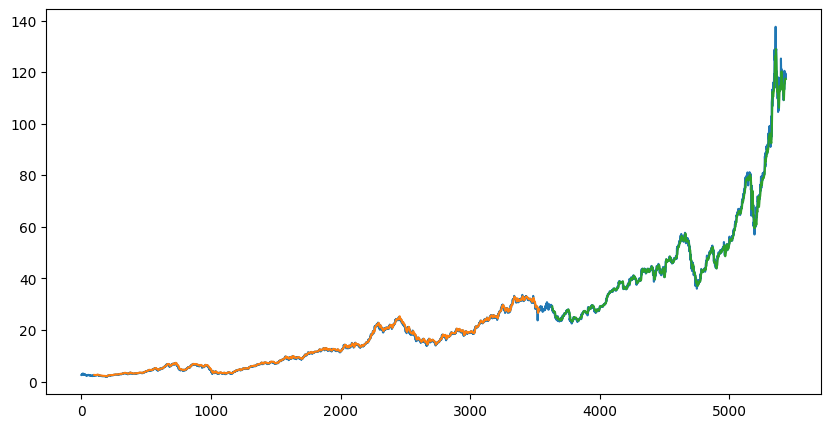

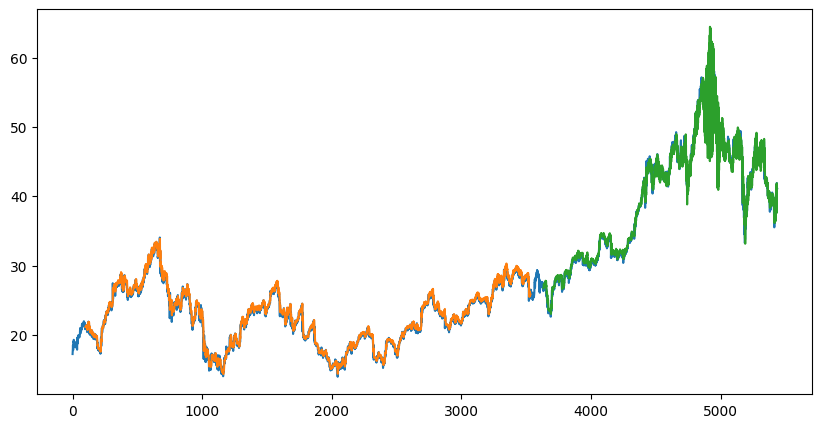

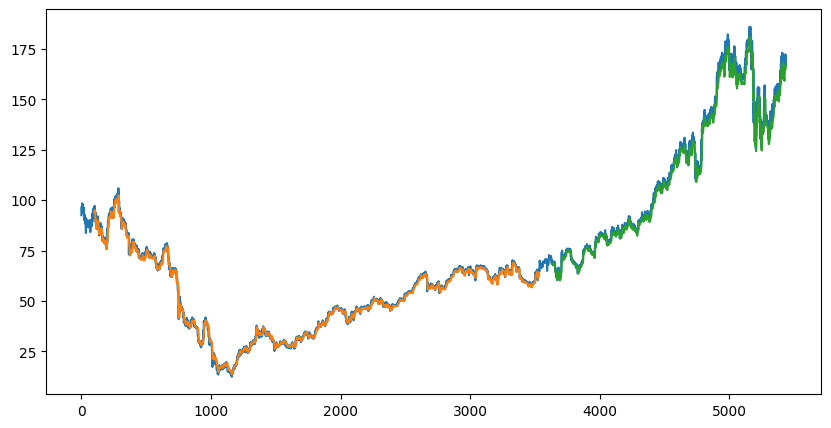

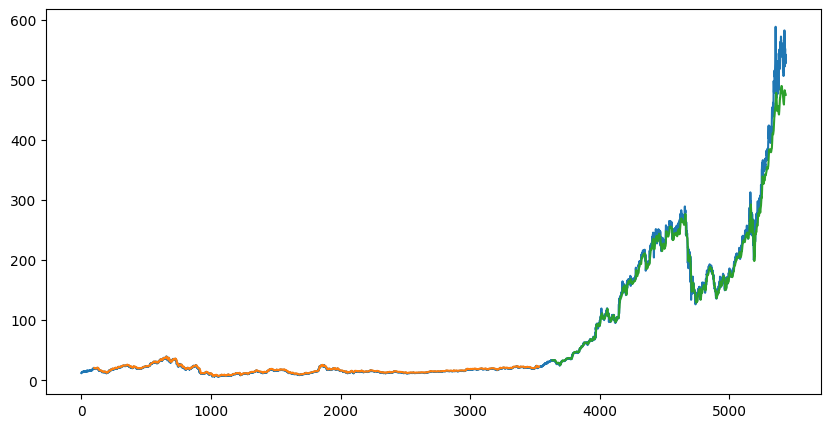

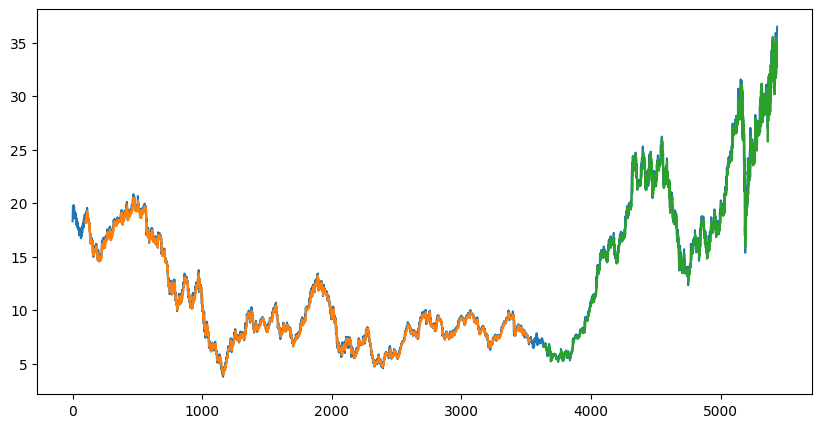

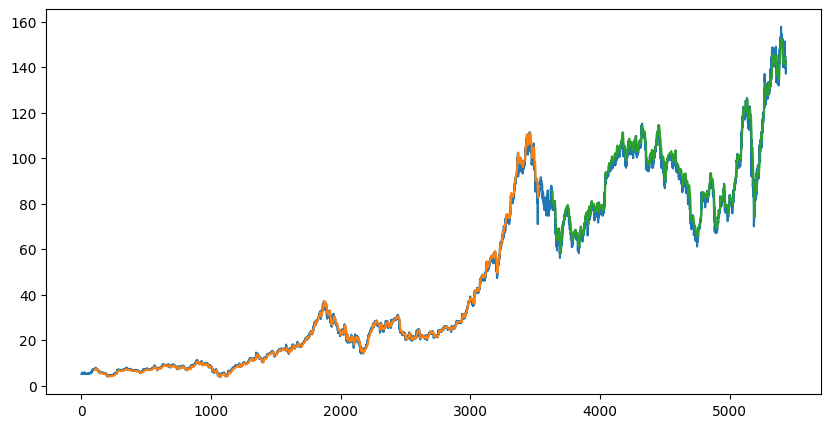

In [14]:
# find all files in BASE_PATH

import os

files = os.listdir(BASE_PATH)
for file in ["AAPL.csv", "CSCO.csv", "MSI.csv", "NVDA.csv", "STM.csv", "SWKS.csv"]:
    if file.endswith(".csv"):
        comp_name = file.split(".")[0]
        run_on(comp_name)